# Ball mapper

This notebook was prepared from an original idea of [Davide Gurnari](https://github.com/dgurnari). 

## Generate data

In [1]:
using LinearAlgebra
using Plots
using Random
using Statistics

We will start by constructing a collection of points sampled from a unit circle.

In [2]:
function noisy_circle(rng, n, noise=0.05)
    x = zeros(n)
    y = zeros(n)
    for i in 1:n
        θ = 2π * rand(rng)
        x[i] = cos(θ) + 2 * noise * (rand(rng) - 0.5)
        y[i] = sin(θ) + 2 * noise * (rand(rng) - 0.5)
    end
    return vcat(x', y')
end

noisy_circle (generic function with 2 methods)

In [3]:
rng = MersenneTwister(72)

MersenneTwister(72)

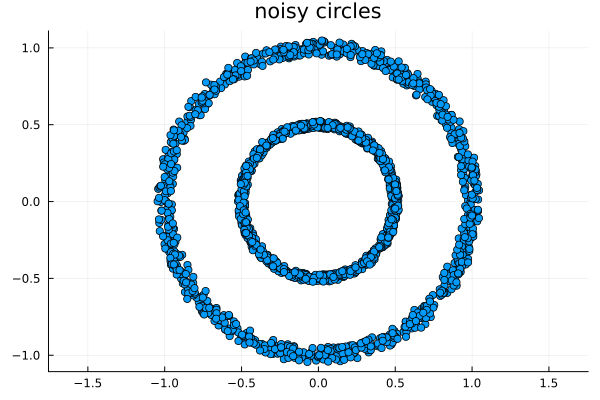

In [4]:
nc = noisy_circle(rng, 1000)
points = hcat(nc, 0.5 .* nc )
scatter(points[1,:], points[2,:]; aspect_ratio=1, legend=false, title="noisy circles")

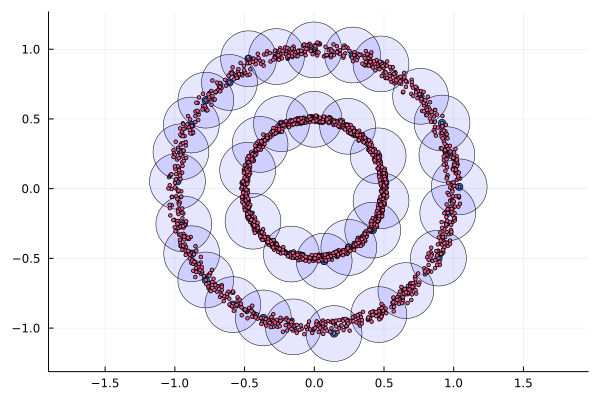

In [24]:
function find_centers( points, ϵ )
    centers = Dict{Int, Int}() # dict of points {idx_v: idx_p, ... }
    centers_counter = 1
    
    for (idx_p, p) in enumerate(eachcol(points))
        
        is_covered = false

        for idx_v in keys(centers)
            distance = norm(p .- points[:, centers[idx_v]])
            if distance <= ϵ
                is_covered = true
                break
            end
        end

        if !is_covered
            centers[centers_counter] = idx_p
            centers_counter += 1
        end
        
    end
    return centers
end
ϵ = 0.2
centers = find_centers( points, ϵ )
idxs = collect(values(centers))
scatter(points[1,idxs], points[2,idxs]; aspect_ratio=1, label="centers")
function ball(h, k, r)
    θ = LinRange(0, 2π, 500)
    h .+ r * sin.(θ), k .+ r * cos.(θ)
end
for i in idxs
    plot!(ball(points[1,i], points[2,i], ϵ), seriestype = [:shape,], lw = 0.5, c = :blue, 
            linecolor = :black, legend = false, fillalpha = 0.1, aspect_ratio = 1)
end
scatter!(points[1,:], points[2,:]; aspect_ratio=1,  label = "points", ms = 2)

In [18]:
function compute_points_covered_by_landmarks( points, centers :: Dict{Int, Int}, ϵ)
    points_covered_by_landmarks = Vector{Int}[]
    for idx_v in keys(centers)
        points_covered_by_landmarks[idx_v] = Int[]
        for (idx_p, p) in enumerate(eachcol(points))
            distance = norm(p .- points[:,centers[idx_v]])
            if distance <= ϵ
                push!(points_covered_by_landmarks[idx_v], idx_p)
            end
        end
    end
    return sort(points_covered_by_landmarks)
end
points_covered_by_landmarks = compute_points_covered_by_landmarks( points, centers, ϵ)

OrderedCollections.OrderedDict{Int64, Vector{Int64}} with 37 entries:
  1  => [1, 33, 42, 47, 48, 78, 112, 115, 117, 136  …  749, 778, 792, 841, 869,…
  2  => [2, 22, 32, 49, 59, 61, 68, 76, 102, 113  …  760, 763, 803, 817, 824, 8…
  3  => [3, 8, 36, 37, 100, 139, 164, 169, 175, 181  …  853, 870, 899, 909, 918…
  4  => [4, 9, 22, 32, 61, 76, 93, 102, 110, 130  …  791, 803, 822, 833, 846, 8…
  5  => [5, 33, 51, 63, 73, 82, 112, 115, 121, 136  …  838, 855, 869, 908, 912,…
  6  => [6, 11, 58, 77, 81, 89, 137, 167, 187, 198  …  871, 872, 898, 933, 945,…
  7  => [7, 60, 94, 104, 106, 123, 143, 184, 188, 221  …  890, 905, 906, 916, 9…
  8  => [10, 97, 183, 198, 200, 209, 222, 232, 256, 263  …  942, 945, 947, 948,…
  9  => [12, 40, 52, 56, 64, 80, 87, 146, 193, 212  …  807, 830, 832, 845, 903,…
  10 => [13, 18, 19, 27, 44, 66, 84, 90, 103, 114  …  839, 840, 867, 873, 881, …
  11 => [14, 21, 29, 57, 72, 95, 124, 137, 171, 180  …  852, 859, 872, 888, 898…
  12 => [15, 17, 24, 30, 88, 91, 106, 1

In [19]:
function compute_graph(points_covered_by_landmarks)
    edges = Tuple{Int,Int}[]
    idxs = collect(keys(points_covered_by_landmarks)) # centers
    for (i, idx_v) in enumerate(idxs[1:end-1]), idx_u in idxs[i+1:end]
        if !isdisjoint(points_covered_by_landmarks[idx_v], points_covered_by_landmarks[idx_u])
            push!(edges, (idx_v,idx_u))
        end
    end
    edges
end
compute_graph(points_covered_by_landmarks)

37-element Vector{Tuple{Int64, Int64}}:
 (1, 5)
 (1, 15)
 (2, 4)
 (2, 18)
 (3, 20)
 (3, 21)
 (4, 20)
 (5, 22)
 (6, 8)
 (6, 11)
 (7, 12)
 (7, 22)
 (8, 16)
 ⋮
 (26, 30)
 (26, 33)
 (27, 28)
 (27, 36)
 (28, 35)
 (29, 35)
 (29, 37)
 (30, 34)
 (31, 32)
 (31, 36)
 (32, 33)
 (34, 37)

In [20]:
using RecipesBase

In [21]:
@userplot EdgesPlot

edgesplot! (generic function with 2 methods)

In [22]:
@recipe function f(gp::EdgesPlot)
    points, centers, edges = gp.args
    idxs = values(centers)
    aspect_ratio := 1
    
    @series begin
        seriestype := :scatter
        points[1,idxs], points[2,idxs]
    end
    for (e1,e2) in edges
        x1, y1 = points[:,centers[e1]]
        x2, y2 = points[:,centers[e2]]
        @series begin
            color := :black
            legend := false
            [x1, x2], [y1, y2]
        end
    end

end

In [23]:
edgesplot(points, centers, points_covered_by_landmarks)

LoadError: ArgumentError: invalid index: [5, 25, 50, 1029, 15, 108, 1003, 10, 28, 1007  …  1024, 4, 16, 23, 2, 13, 35, 53, 1001, 1002] of type Base.ValueIterator{Dict{Int64, Int64}}

In [11]:
function compute_labels(points, points_covered_by_landmarks)
    
    labels = zeros(Int, size(points,2))
    idxs = collect(keys(points_covered_by_landmarks)) # centers
    color = 1
    for (i, idx_v) in enumerate(idxs[1:end-1]), idx_u in idxs[i+1:end]
        if !isdisjoint(points_covered_by_landmarks[idx_v], points_covered_by_landmarks[idx_u])
            labels[idx_v] = color
            labels[idx_u] = color
        else
            color += 1
        end
    end
    labels
end

labels = compute_labels(points, points_covered_by_landmarks)

2000-element Vector{Int64}:
  13
  49
  84
 115
 148
 166
 205
   0
   0
 227
   0
 261
 286
   ⋮
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0

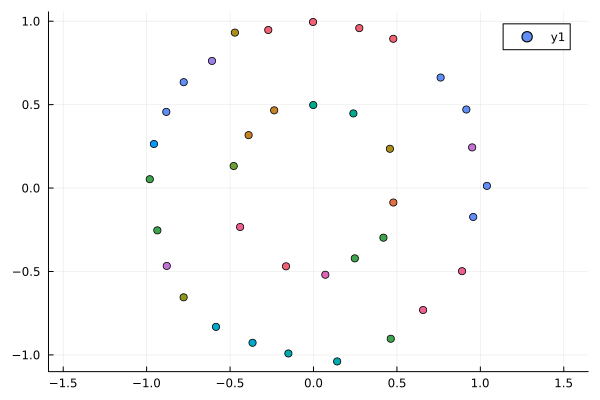

In [12]:
idxs = collect(keys(points_covered_by_landmarks))
scatter(points[1,idxs], points[2,idxs], c = labels[idxs], aspect_ratio=1)

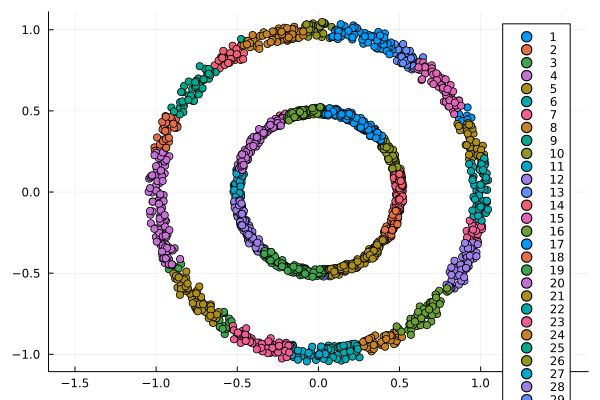

In [13]:
function compute_colors(points, points_covered_by_landmarks)
    n = size(points, 2)
    colors = zeros(Int, n)
    for (i, cluster) in enumerate(values(points_covered_by_landmarks))
        colors[cluster] .= i
    end
    return colors
end
colors = compute_colors(points, points_covered_by_landmarks)
scatter(points[1,:], points[2,:], group = colors, aspect_ratio=1)

In [14]:
using Graphs

function ball_mapper_graph(points_covered_by_landmarks)
    idxs = collect(keys(points_covered_by_landmarks))
    nv = length(idxs)
    graph = Graph(nv)
    for (i, idx_v) in enumerate(idxs[1:end-1]), idx_u in idxs[i+1:end]
        if !isdisjoint(points_covered_by_landmarks[idx_v], points_covered_by_landmarks[idx_u])
            add_edge!( graph, idx_v, idx_u )
        end
    end
    return graph
end   

g = ball_mapper_graph(points_covered_by_landmarks)

{37, 13} undirected simple Int64 graph

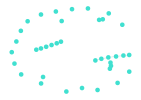

In [17]:
using GraphPlot
gplot(g)